In [21]:
import sys
from os.path import join, abspath, pardir
from glob import glob
import numpy as np
import pandas as pd
import vaex
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from time import time
from multiprocessing import Pool
import emcee
import corner
from scipy.stats import norm, uniform
# styling
plt.style.use('seaborn-v0_8-whitegrid')
params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern"]}
plt.rcParams.update(params)

In [2]:
# import utils
root_dir = abspath(pardir)
root_dir

'/home2/s20321005/Thesis-Project'

In [3]:
if root_dir not in sys.path:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/4_Gravity',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project']

In [4]:
from utils import safe_mkdir, fw, nu_mod

In [5]:
root_data_dir = abspath(join(root_dir, "Data"))
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [6]:
data_baryon_dir = join(root_data_dir, "Baryon")
data_velocity_dir = join(root_data_dir, "Velocity-Distribution-2")
data_eff_dir = join(root_data_dir, "Effective-Volume-2")
data_dir = join(root_data_dir, "MCMC-2")

In [7]:
# load baryons components
df_baryon = vaex.open(join(data_baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [15]:
rhos = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s

e_rhos = df_baryon["e_rho"].to_numpy()  # Msun/pc^3
e_sigmaz = df_baryon["e_sigma_z"].to_numpy() # km/s
dpi=100

In [24]:
# load data from files
number_files = glob(join(data_eff_dir, "*.hdf5"))
number_files.sort()
velocity_files = glob(join(data_velocity_dir, "gaia_*.hdf5"))
velocity_files.sort()
velocity_popt_files = glob(join(data_velocity_dir, "popt_gaia_*.hdf5"))
velocity_popt_files.sort()

# Functions

## probs

In [11]:
def log_prior(theta, locs, scales, norm_list, uni_list):
    pars_list = norm_list+uni_list
    result = 0
    for item in pars_list:
        if item in uni_list:
            result += np.sum(uniform.logpdf(theta[item], loc=locs[item], scale=scales[item]))
        elif item in norm_list:
            result += np.sum(norm.logpdf(theta[item], loc=locs[item], scale=scales[item]))
    return result

In [12]:
def log_likelihood(theta, zdata, wdata):
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata
    Fz = nu_mod(zmid, **theta)
    Fw = fw(wmid, **theta)
    resz = np.sum(norm.logpdf(zdens, loc=Fz, scale=zerr))
    resw = np.sum(norm.logpdf(wdens, loc=Fw, scale=werr))
    return resz + resw

In [39]:
def log_posterior_DM(theta, data, locs, scales, dim, norm_list, uni_list):
    zdata, wdata = data
    theta_dict = dict(
        rhos=theta[:12],
        sigmaz=theta[12:24],
        rhoDM=theta[24],
        log_nu0=theta[25],
        zsun=theta[26],
        R=theta[27],
        w0=theta[28:28+dim],
        log_sigma_w=theta[28+dim:28+2*dim],
        a=theta[28+2*dim:28+3*dim]
    )
    log_prior_ = log_prior(theta_dict, locs, scales, norm_list, uni_list)
    if not np.isfinite(log_prior_):
        return -np.inf
    
    theta_dict['sigmaDD'] = 0
    theta_dict['hDD'] = 1
    theta_dict['nu0'] = np.exp(theta_dict['log_nu0'])
    theta_dict['sigma_w'] = np.exp(theta_dict['log_sigma_w'])
    
    return log_prior_ + log_likelihood(theta_dict, zdata, wdata)

## utils

In [14]:
def load_data(index, number_files, velocity_files, velocity_popt_files):
    name = number_files[index].split('/')[-1]
    df_number = vaex.open(number_files[index])
    df_velocity = vaex.open(velocity_files[index])
    df_popt = vaex.open(velocity_popt_files[index])
    popt = df_popt['popt'].to_numpy()
    wdens= df_velocity['wnum'].to_numpy()
    werr = df_velocity['werr'].to_numpy()
    wmid = df_velocity['w'].to_numpy()
    dim = len(popt)//3

    zdens = df_number['density_corr'].to_numpy()
    zerr = df_number['density_err'].to_numpy()
    zmid = df_number['z'].to_numpy()

    w0 = []
    sigma_w = []
    a_raw = []

    for i in range(len(popt)//3):
        w0_i = popt[3*i+1]
        sigma_w_i = popt[3*i+2]
        a_raw_i = popt[3*i]
        
        w0.append(w0_i)
        sigma_w.append(sigma_w_i)
        a_raw.append(a_raw_i)

    w0 = np.array(w0)
    sigma_w = np.array(sigma_w)
    a_raw = np.array(a_raw)

    zdata = (zmid, zdens, zerr)
    wdata = (wmid, wdens, werr)
    data = (zdata, wdata)
    return data, dim, w0, sigma_w, a_raw, name

In [16]:
def plot_data(data, path=None):
    zdata, wdata = data
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata

    # plot 2 subplot
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='.')
    axes[0].set_xlabel(r'$z$ [pc]')
    axes[0].set_ylabel(r'$\rho(z)$ [pc$^{-3}$]')
    axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.')
    axes[1].set_xlabel(r'$w$ [km/s]')
    axes[1].set_ylabel(r'$f_w$')
    if path is not None:
        fig.savefig(path, dpi=dpi)
    fig.show()

In [17]:
def initialize_prior_dm(w0, rhos, sigmaz, e_rhos, e_sigmaz, sigma_w, a_raw, dim):
    locs = dict(
        rhos=rhos,
        sigmaz=sigmaz,
        rhoDM=-0.05, 
        log_nu0=np.log(1E-6), 
        zsun=-40, 
        R=3.4E-3, 
        w0=w0-10, 
        log_sigma_w=np.log(sigma_w*0.7), 
        a=a_raw*0.7
    )

    scales = dict(
        rhos=e_rhos,
        sigmaz=e_sigmaz,
        rhoDM=0.1-locs['rhoDM'], 
        log_nu0=np.log(1E-4)-locs['log_nu0'], 
        zsun=40-locs['zsun'], 
        R=0.6E-3, 
        w0=np.repeat(20, dim), 
        log_sigma_w=np.log(sigma_w*1.3)-locs['log_sigma_w'], 
        a=np.abs(a_raw*0.6)
    )
    uni_list_DM = ['rhoDM', 'log_nu0', 'zsun', 'log_sigma_w', 'w0', 'a']
    norm_list_DM = ['R', 'rhos', 'sigmaz']
    return locs, scales, uni_list_DM, norm_list_DM

In [18]:
def initialize_walkers_dm(locs, scales, dim):
    theta = np.concatenate([np.ravel(x) for x in locs.values()])
    ndim = len(theta)
    nwalkers = ndim*2+1

    rhos_0 = np.random.normal(loc=locs['rhos'], scale=scales['rhos'], size=(nwalkers, 12))
    sigmaz_0 = np.random.normal(loc=locs['sigmaz'], scale=scales['sigmaz'], size=(nwalkers, 12))
    rhoDM_0 = np.random.uniform(low=locs['rhoDM'], high=locs['rhoDM']+scales['rhoDM'], size=nwalkers)
    log_nu0_0 = np.random.uniform(low=locs['log_nu0'], high=locs['log_nu0']+scales['log_nu0'], size=nwalkers)
    zsun_0 = np.random.uniform(low=locs['zsun'], high=locs['zsun']+scales['zsun'], size=nwalkers)
    R_0 = np.random.normal(loc=locs['R'], scale=scales['R'], size=nwalkers)
    w0_0 = np.random.uniform(low=locs['w0'], high=locs['w0']+scales['w0'], size=(nwalkers, dim))
    log_sigma_w_0 = np.random.uniform(low=locs['log_sigma_w'], high=locs['log_sigma_w']+scales['log_sigma_w'], size=(nwalkers, dim))
    a_0 = np.random.uniform(low=locs['a'], high=locs['a']+scales['a'], size=(nwalkers, dim))

    p0 = np.array([*rhos_0.T, *sigmaz_0.T, rhoDM_0, log_nu0_0, zsun_0, R_0, *w0_0.T, *log_sigma_w_0.T, *a_0.T]).T
    return p0, ndim, nwalkers

In [19]:
def plot_chain(samples, labels, figsize=(10, 7), alpha=0.3, start=0, skip=0, path=None):
    num = len(labels)
    fig, axes = plt.subplots(num, figsize=figsize, sharex=True)
    if len(labels) == 1:
      axes = [axes]
    for i in range(num):
        ax = axes[i]
        ax.plot(samples[start:, :, skip+i], "k", alpha=alpha)
        ax.set_xlim(0, len(samples[start:, :, skip+i]))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number")
    if path is not None:
        fig.savefig(path, dpi=dpi)
    fig.show()

In [56]:
def run_mcmc(nwalkers, ndim, p0, labels, log_posterior, args, cores=16, plot=False, step=500, skip=0, start=0, path=None):
    os.environ["OMP_NUM_THREADS"] = str(cores)
    sampler_ = 0
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, 
            ndim, 
            log_posterior, 
            args=args, 
            pool=pool
        )
        t0 = time()
        sampler.run_mcmc(p0, step, progress=True)
        samples = sampler.get_chain().copy()

        rho_b = np.sum(samples[:, :, 0:12], axis=2)
        samples = samples[:, :, 24:29]
        samples[:, :, 0] = samples[:, :, 0]/1E-2
        samples[:, :, 3] = samples[:, :, 3]/1E-3
        # shift
        samples[:, :, 4] = samples[:, :, 3]
        samples[:, :, 3] = samples[:, :, 2]
        samples[:, :, 2] = samples[:, :, 1]
        samples[:, :, 1] = rho_b/1E-2
        t1 = time()
        multi_time = t1 - t0
        if plot:
            plot_chain(samples, labels, figsize=(10,15), skip=skip, start=start, path=path)
        print("Multiprocessing took {0:.1f} seconds".format(multi_time))
        sampler_ = sampler
    return sampler_

In [60]:
def plot_corner_dm(sampler, path=None):
    flat_samples = sampler.get_chain(flat=True).copy()
    rho_b = np.sum(flat_samples[:, 0:12], axis=1)
    flat_samples = flat_samples[:, 24:29]
    flat_samples[:, 0] = flat_samples[:, 0]/1E-2
    flat_samples[:, 1] = np.exp(flat_samples[:, 1])/1E-5
    flat_samples[:, 3] = flat_samples[:, 3]/1E-3
    # shift
    flat_samples[:, 4] = flat_samples[:, 3]
    flat_samples[:, 3] = flat_samples[:, 2]
    flat_samples[:, 2] = flat_samples[:, 1]
    flat_samples[:, 1] = rho_b/1E-2

    labels = [r"$\rho_{DM}\times 10^2 [M_{\odot}$ pc$^{-3}]$",
          r"$\rho_{b}\times 10^2 [M_{\odot}$ pc$^{-3}]$",
          r"$\nu_0\times 10^5 [$pc$^{-3}]$" , 
          r"$z_{\odot}$ [pc]", 
          r"$R\times 10^3 [M_{\odot}$ pc$^{-3}]$"]
    fig = corner.corner(
        flat_samples, labels=labels,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True, title_kwargs={"fontsize": 12},
    )
    if path is not None:
        fig.savefig(path, dpi=dpi)
    fig.show()

In [63]:
def plot_fitting_dm(sampler, data, dim, alpha=0.01, n=200, log=False, path=None):
    zdata, wdata = data
    zmid, zdens, zerr = zdata
    wmid, wdens, werr = wdata
    # plot two subplot
    flat_samples = sampler.get_chain(flat=True).copy()
    zs = np.linspace(zmid.min(), zmid.max(), 100)
    ws = np.linspace(wmid.min(), wmid.max(), 100)

    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    axes[0].errorbar(zmid, zdens, yerr=zerr, fmt='.', label='data')
    axes[0].set_xlabel(r'$z$')
    axes[0].set_ylabel(r'$\nu(z)$')
    axes[0].legend()
    axes[1].errorbar(wmid, wdens, yerr=werr, fmt='.', label='data')
    axes[1].set_xlabel(r'w')
    axes[1].set_ylabel(r'fw')
    axes[1].legend()
    if log:
        axes[0].set_yscale('log')
        axes[1].set_yscale('log')
    for i in tqdm(range(n)):
        index = np.random.randint(0, len(flat_samples))
        theta_dict = dict(
            rhos=flat_samples[index, :12],
            sigmaz=flat_samples[index, 12:24],
            rhoDM=flat_samples[index, 24],
            sigmaDD=0, 
            hDD=1, 
            nu0=np.exp(flat_samples[index, 25]),
            zsun=flat_samples[index, 6],
            R=flat_samples[index, 27],
            w0=flat_samples[index, 28:28+dim],
            sigma_w=np.exp(flat_samples[index, 28+dim:28+2*dim]),
            a=flat_samples[index, 28+2*dim:28+3*dim]
        )
        nu = nu_mod(zs, **theta_dict)
        axes[0].plot(zs, nu, label='model', c="r", alpha=alpha)
        Fw = fw(ws, **theta_dict)
        axes[1].plot(ws, Fw, label='model', c="r", alpha=alpha)
    if path is not None:
        fig.savefig(path, dpi=dpi)
    fig.show()

gaia_(-0.10)_(0.04).hdf5


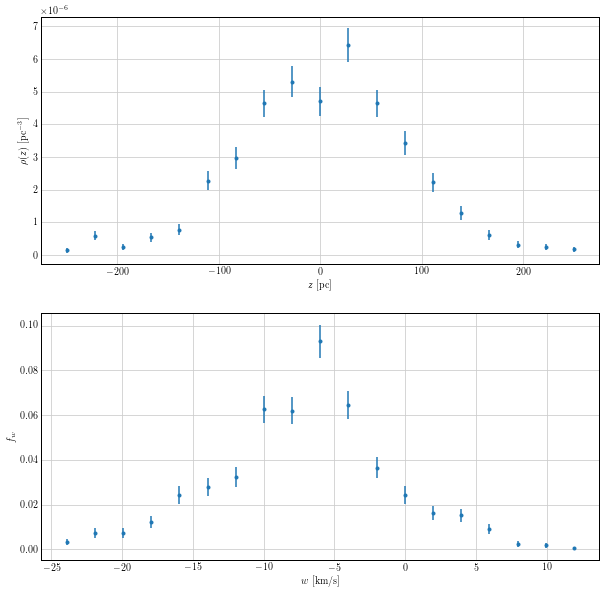

In [25]:
index = 0
data, dim, w0, sigma_w, a_raw, name = load_data(index, number_files, velocity_files, velocity_popt_files)
print(name)
## plot data
plot_data(data)

In [29]:
## initialize prior
locs, scales, uni_list_DM, norm_list_DM = initialize_prior_dm(w0, rhos, sigmaz, e_rhos, e_sigmaz, sigma_w, a_raw, dim)

In [37]:
# initialize walkers
p0, ndim, nwalkers = initialize_walkers_simple_dm(locs, scales, dim)

100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


Multiprocessing took 1.8 seconds


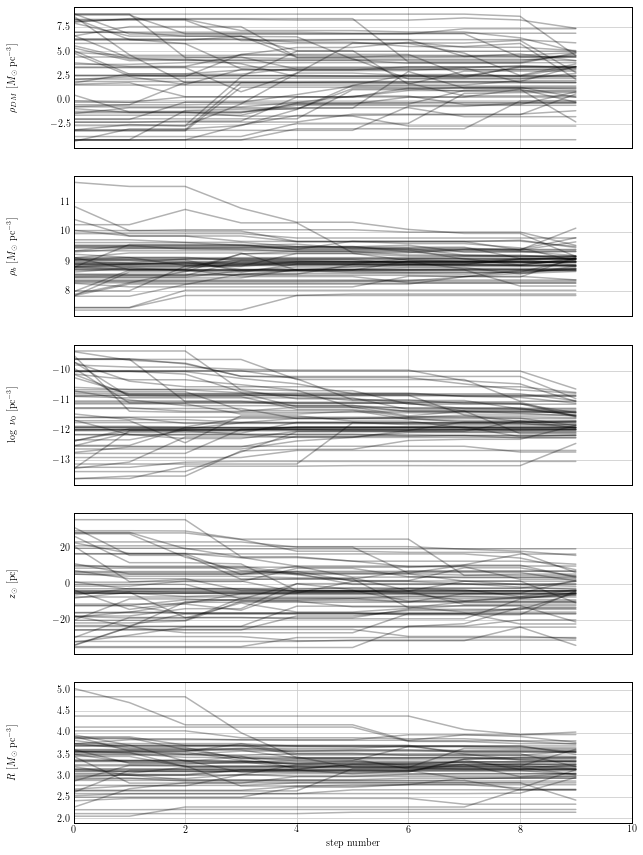

In [71]:
labels = [r"$\rho_{DM}\ [M_{\odot}$ pc$^{-3}]$",
          r"$\rho_{b}\ [M_{\odot}$ pc$^{-3}]$",
          r"$\log\ \nu_0\ [$pc$^{-3}]$" , 
          r"$z_{\odot}$ [pc]", 
          r"$R\ [M_{\odot}$ pc$^{-3}]$"]
sampler = run_mcmc(
    nwalkers, ndim, p0, labels, log_posterior_DM, cores=16,
    args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
    plot=True, step=10
)

100%|██████████| 2000/2000 [04:48<00:00,  6.94it/s]


Multiprocessing took 288.6 seconds


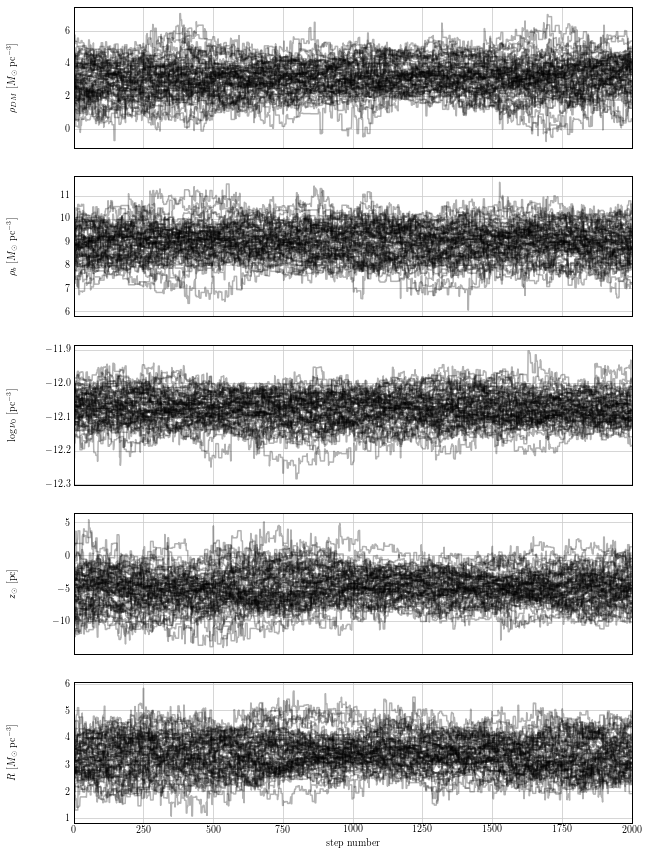

In [58]:
next_p0 = sampler.get_chain()[-1]
sampler_new = run_mcmc(
    nwalkers, ndim, next_p0, labels, log_posterior_DM, cores=16,
    args=[data, locs, scales, dim, norm_list_DM, uni_list_DM], 
    plot=True, step=2000
)

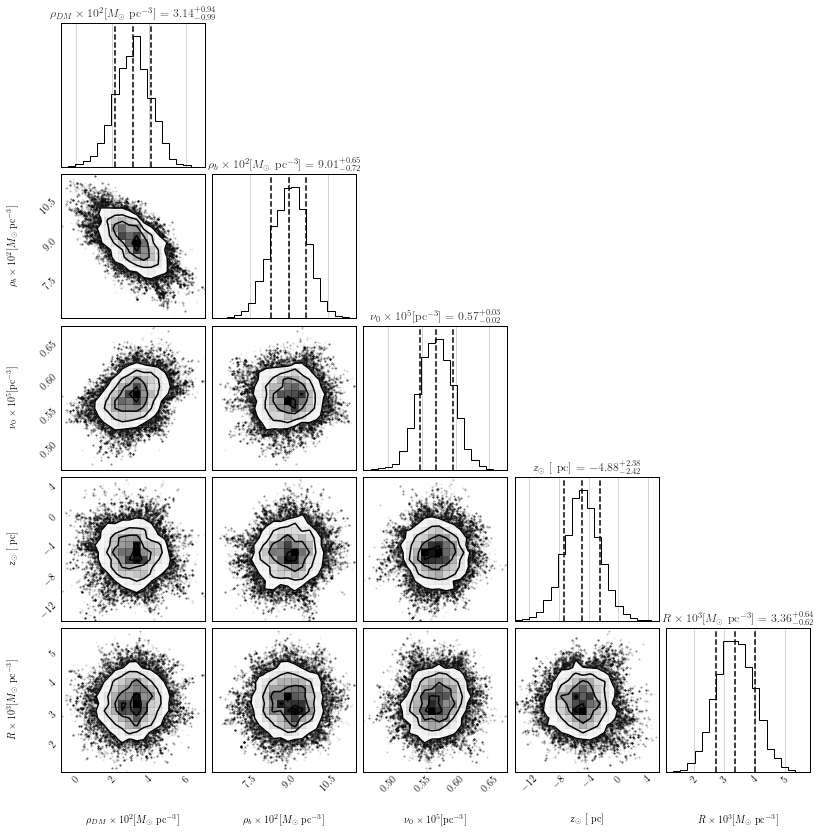

In [61]:
plot_corner_dm(sampler_new)

100%|██████████| 500/500 [00:11<00:00, 42.75it/s]


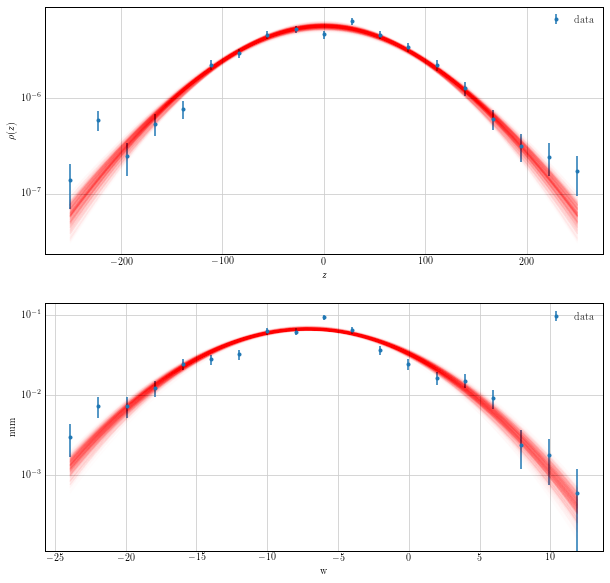

In [64]:
plot_fitting_dm(sampler_new, data, dim, alpha=0.01, n=500, log=True)

In [65]:
flat_samples = sampler_new.get_chain().copy()
log_posterior_chain = sampler_new.get_log_prob().copy()
thetas = []
t0 = time()
for i, post in enumerate(log_posterior_chain.T):
    for samples, lg_posterior in zip(tqdm(flat_samples[:, i], desc=f"{i}/{nwalkers}", leave=False), post):
        theta = {
            "rhos": samples[:12],
            "sigmaz": samples[12:24],
            "rhoDM": samples[24],
            "log_nu0": samples[25],
            "zsun": samples[26],
            "R": samples[27],
            "w0": samples[28:28+dim],
            "log_sigma_w": samples[28+dim:28+2*dim],
            "a": samples[28+2*dim:28+3*dim]
        }
        lg_prior = log_prior(theta, locs, scales, norm_list_DM, uni_list_DM)
        theta['log_prior'] = lg_prior
        theta['log_posterior'] = lg_posterior
        theta['log_likelihood'] = lg_posterior - lg_prior
        del theta['w0'], theta['log_sigma_w'], theta['a'], theta['rhos'], theta['sigmaz']
        for j in range(dim):
            theta[f"w0_{j}"] = samples[4+j]
            theta[f"log_sigma_w_{j}"] = samples[4+dim+j]
            theta[f"a_{j}"] = samples[4+2*dim+j]
        for j in range(12):
            theta[f"rhob_{j}"] = samples[j]
            theta[f"sigmaz_{j}"] = samples[12+j]
        theta['walker'] = i
        thetas.append(theta)
# for samples in tqdm(flat_samples):
t1 = time()
print(f"Time: {t1-t0:.2f} s")
df = pd.DataFrame(thetas)
df

Time: 157.89 s


,rhoDM,log_nu0,zsun,R,log_prior,log_posterior,log_likelihood,w0_0,log_sigma_w_0,a_0,...,sigmaz_7,rhob_8,sigmaz_8,rhob_9,sigmaz_9,rhob_10,sigmaz_10,rhob_11,sigmaz_11,walker
0,0.023834,-12.097431,-2.839211,0.002655,49.529015,374.680176,325.151161,0.000603,0.001742,0.001958,...,18.802536,0.007247,18.291643,0.020180,14.094002,0.006865,14.278705,0.002467,13.871146,0
1,0.023834,-12.097431,-2.839211,0.002655,49.529015,374.680176,325.151161,0.000603,0.001742,0.001958,...,18.802536,0.007247,18.291643,0.020180,14.094002,0.006865,14.278705,0.002467,13.871146,0
2,0.023834,-12.097431,-2.839211,0.002655,49.529015,374.680176,325.151161,0.000603,0.001742,0.001958,...,18.802536,0.007247,18.291643,0.020180,14.094002,0.006865,14.278705,0.002467,13.871146,0
3,0.023834,-12.097431,-2.839211,0.002655,49.529015,374.680176,325.151161,0.000603,0.001742,0.001958,...,18.802536,0.007247,18.291643,0.020180,14.094002,0.006865,14.278705,0.002467,13.871146,0
4,0.023834,-12.097431,-2.839211,0.002655,49.529015,374.680176,325.151161,0.000603,0.001742,0.001958,...,18.802536,0.007247,18.291643,0.020180,14.094002,0.006865,14.278705,0.002467,13.871146,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125995,0.044163,-12.040303,-5.431942,0.002593,50.499564,375.398905,324.899342,0.000507,0.001990,0.001799,...,17.315241,0.007532,20.582866,0.023108,23.938179,0.004216,20.412537,0.000786,27.310919,62
125996,0.044163,-12.040303,-5.431942,0.002593,50.499564,375.398905,324.899342,0.000507,0.001990,0.001799,...,17.315241,0.007532,20.582866,0.023108,23.938179,0.004216,20.412537,0.000786,27.310919,62
125997,0.044163,-12.040303,-5.431942,0.002593,50.499564,375.398905,324.899342,0.000507,0.001990,0.001799,...,17.315241,0.007532,20.582866,0.023108,23.938179,0.004216,20.412537,0.000786,27.310919,62
125998,0.044163,-12.040303,-5.431942,0.002593,50.499564,375.398905,324.899342,0.000507,0.001990,0.001799,...,17.315241,0.007532,20.582866,0.023108,23.938179,0.004216,20.412537,0.000786,27.310919,62


In [69]:
## save
df_dm = vaex.from_pandas(df)
df_dm.export(join(data_dir, f"dm_full_{name}"), progress=True)

export(hdf5) [########################################] 100.00% elapsed time  :     0.18s =  0.0m =  0.0h
 